In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Data

In [2]:
from sklearn.datasets import load_files

test_dir = 'C:/users/Patrick/Documents/python/fruits360/fruits-360_dataset/fruits-360/Test'
train_dir = 'C:/users/Patrick/Documents/python/fruits360/fruits-360_dataset/fruits-360/Training'

      
def load_data(str_dir):
      dataset = load_files(str_dir) # Note this function automatically shuffles the data
      data = np.array(dataset['filenames'])
      target_names = np.array(dataset['target_names'])
      targets = np.array(dataset['target'])
      return data, targets, target_names
      
xtrain, ytrain, target_labels = load_data(train_dir)
xtest, ytest, _ = load_data(test_dir)

In [3]:
num_classes = len(set(ytrain))

print(f'Train shape: {xtrain.shape}')
print(f'Test shape: {xtest.shape}')
print(f'Number of classes: {num_classes}')

Train shape: (67692,)
Test shape: (22688,)
Number of classes: 131


In [4]:
len_train = int(len(xtrain)/2)
len_test = int(len(xtest)/2)

xtrain = xtrain[:len_train]
xtest = xtest[:len_test]

# One-hot encode the labels
ytrain = tf.keras.utils.to_categorical(ytrain[:len_train])
ytest = tf.keras.utils.to_categorical(ytest[:len_test])

print(ytest.shape) # confirm the one hot encoding was successful
ytrain[0]

(11344, 131)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [5]:
# Create testing and validation sets
xtest, xvalid = xtest[int(xtest.shape[0]/2):], xtest[:int(xtest.shape[0]/2)]
ytest, yvalid = ytest[int(ytest.shape[0]/2):], ytest[:int(ytest.shape[0]/2)]
print(f'xtest size: {xtest.shape}')
print(f'xvalid size: {xvalid.shape} \n')
print(f'ytest size: {ytest.shape}')
print(f'yvalid size: {yvalid.shape}')

xtest size: (5672,)
xvalid size: (5672,) 

ytest size: (5672, 131)
yvalid size: (5672, 131)


# Convert files to arrays

We have loaded them in as just file names. We also normalize the data at this step.

Note each image is 100 x 100 x 3 where 3 is the number of color channels.

In [6]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def image_loader(data):
    images = []
    for file in data:
        images.append(img_to_array(load_img(file)))
    return images

xtrain = np.array(image_loader(xtrain))
xtest = np.array(image_loader(xtest))
xvalid = np.array(image_loader(xvalid))

print(f'Training data shape: {xtrain.shape}')
print(f'Test data shape: {xtest.shape}')
print(f'Validation data shape: {xvalid.shape}')

Training data shape: (33846, 100, 100, 3)
Test data shape: (5672, 100, 100, 3)
Validation data shape: (5672, 100, 100, 3)


In [7]:
xtrain = xtrain/255
xtest = xtest/255
xvalid = xvalid/255

# Build the CNN

In [8]:
from tensorflow import keras

model= keras.models.Sequential()

# First Convolution
model.add(keras.layers.Conv2D(filters = 16, kernel_size=2, input_shape=(100,100,3), padding='same', activation='ReLU'))
model.add(keras.layers.MaxPooling2D(pool_size=2))

# Second Convolution
model.add(keras.layers.Conv2D(filters = 32, kernel_size=2, activation='ReLU', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=2))

# Third Convolution
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, activation='ReLU', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=2))

# Fourth Convolution
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, activation='ReLU', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=2))

# Normalization
model.add(keras.layers.Dropout(0.3))

# Classifier
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(150, activation = 'ReLU'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

## Compile CNN

In [9]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = 'accuracy')

## Train Model

In [10]:
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333) 
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))
batch_size = 32

checkpoint = keras.callbacks.ModelCheckpoint('fruit_classifier.hdf5', verbose = 1, save_best_only=True)

history = model.fit(xtrain, ytrain,
                   batch_size=batch_size,
                   epochs=30,
                   validation_data = (xvalid, yvalid),
                   callbacks = [checkpoint],
                   verbose=2,
                   shuffle=True)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.48036, saving model to fruit_classifier.hdf5
1058/1058 - 14s - loss: 1.9186 - accuracy: 0.4921 - val_loss: 0.4804 - val_accuracy: 0.8729 - 14s/epoch - 13ms/step
Epoch 2/30

Epoch 00002: val_loss improved from 0.48036 to 0.31039, saving model to fruit_classifier.hdf5
1058/1058 - 8s - loss: 0.4258 - accuracy: 0.8609 - val_loss: 0.3104 - val_accuracy: 0.9136 - 8s/epoch - 8ms/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.31039 to 0.20875, saving model to fruit_classifier.hdf5
1058/1058 - 8s - loss: 0.2421 - accuracy: 0.9190 - val_loss: 0.2088 - val_accuracy: 0.9487 - 8s/epoch - 8ms/step
Epoch 4/30

Epoch 00004: val_loss improved from 0.20875 to 0.19362, saving model to fruit_classifier.hdf5
1058/1058 - 8s - loss: 0.1722 - accuracy: 0.9450 - val_loss: 0.1936 - val_accuracy: 0.9556 - 8s/epoch - 8ms/step
Epoch 5/30

Epoch 00005: val_loss improved from 0.19362 to 0.19097, saving model to fruit_classifier.hdf5
1058/1058 - 8s - lo

In [11]:
score = model.evaluate(xtest, ytest, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9793723821640015


<Figure size 432x288 with 0 Axes>

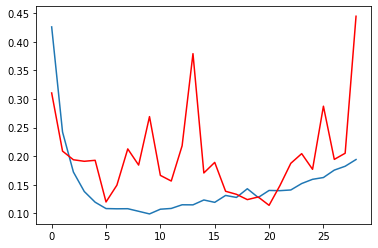

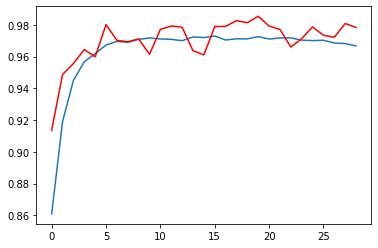

<Figure size 432x288 with 0 Axes>

In [12]:
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

train_accuracy = history.history['accuracy'][1:]
val_accuracy = history.history['val_accuracy'][1:]

epochs = range(len(train_loss))

plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss, c='red')
plt.figure()

plt.plot(epochs, train_accuracy)
plt.plot(epochs, val_accuracy, c='red')
plt.figure()

# Visualize some filters

In [13]:
convolution_weights = {}
for layer in model.layers:
    if 'conv' in layer.name:
        weights = layer.get_weights()[0]
        w_min, w_max = weights.min(), weights.max()
        weights = (weights-w_min)/(w_max-w_min)
        convolution_weights[layer.name] = weights

(2, 2, 3, 16) (2, 2, 16, 32) (2, 2, 32, 64) (2, 2, 64, 128)


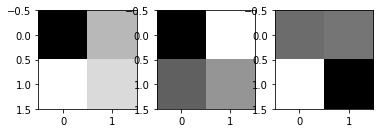

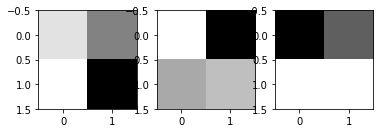

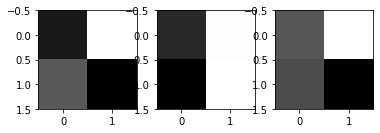

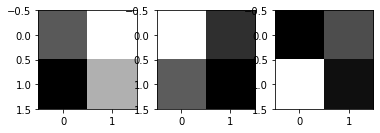

In [14]:
conv1 = convolution_weights['conv2d']
conv2 = convolution_weights['conv2d_1']
conv3 = convolution_weights['conv2d_2']
conv4 = convolution_weights['conv2d_3']
convolutions = [conv1, conv2, conv3, conv4]
print(conv1.shape, conv2.shape, conv3.shape, conv4.shape)

for conv in convolutions:
    for j in range(3):
        ax = plt.subplot(1,3,j+1)
        plt.imshow(conv[:,:,j,5],cmap='gray')
    plt.show()

# Visualize some featuremaps

In [15]:
convolution_layers = []
for ix, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        convolution_layers.append(layer)
        print(ix)


0
2
4
6


In [72]:
import os
model_conv1 = keras.Model(inputs=model.inputs, 
                          outputs=model.layers[1].output)

img = load_img('32_100.jpg')
img = img_to_array(img)
print(img.shape)
img = np.expand_dims(img, axis = 0)
img = img/255


(100, 100, 3)


In [17]:
feature_maps = model_conv1.predict(img)

(1, 50, 50, 16)


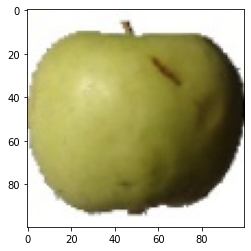

In [18]:
orig = load_img('32_100.jpg')
print(feature_maps.shape)
plt.imshow(orig)

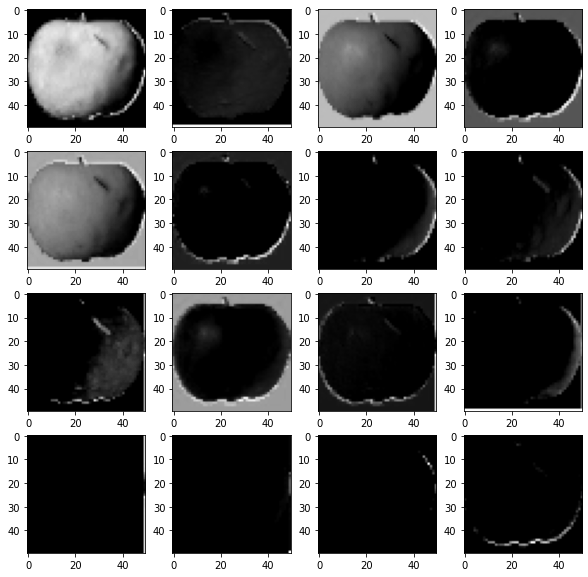

In [19]:
square = int(np.sqrt(feature_maps.shape[-1]))
ix = 0
f, ax = plt.subplots(square, square, figsize = (10, 10))
for axes in ax:
    for axis in axes:
        axis.imshow(feature_maps[0,:,:,ix], cmap = 'gray')
        ix += 1


In [20]:
indices = [0, 2, 4, 6]
output = [model.layers[i+1].output for i in indices]
model_convolutions = keras.Model(inputs = model.inputs, outputs = output)
feature_maps = model_convolutions.predict(img)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FEATURES FOR LAYER 0~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


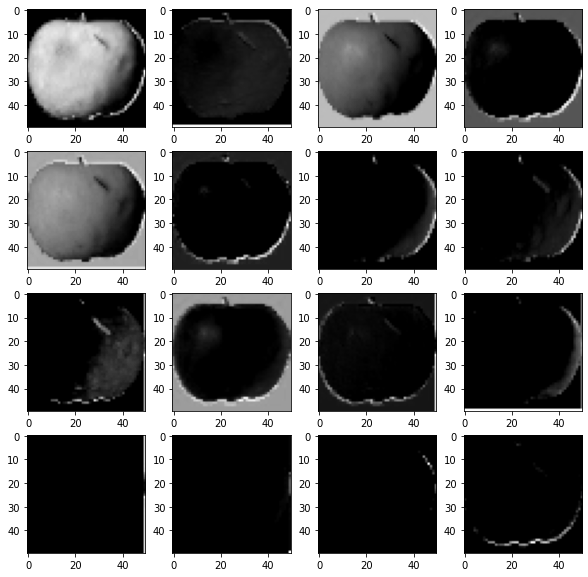

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FEATURES FOR LAYER 1~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


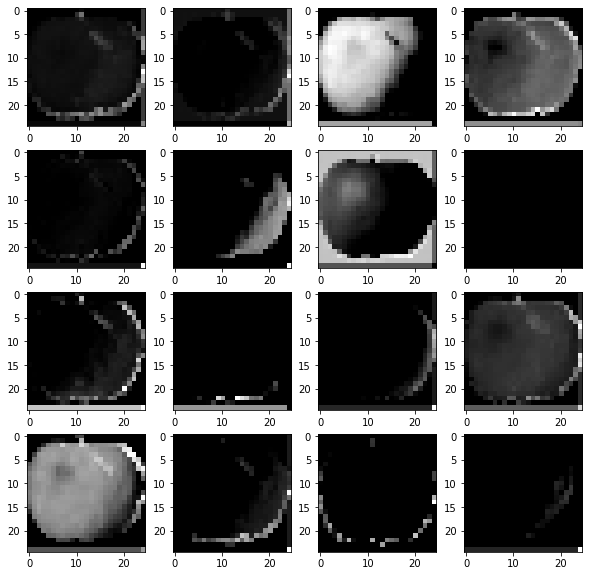

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FEATURES FOR LAYER 2~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


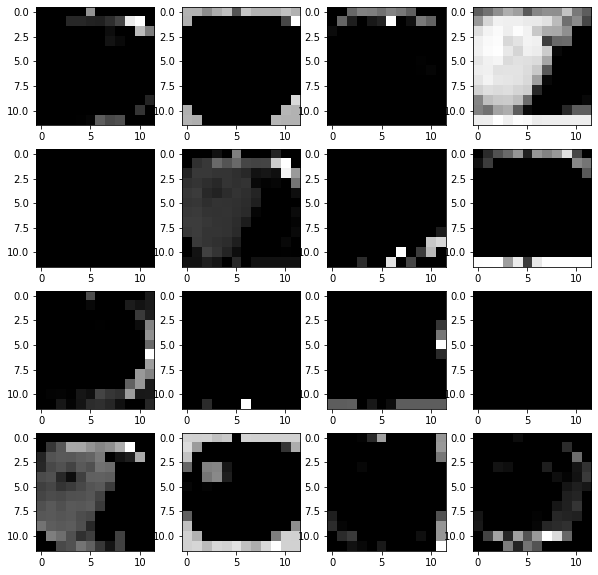

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FEATURES FOR LAYER 3~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


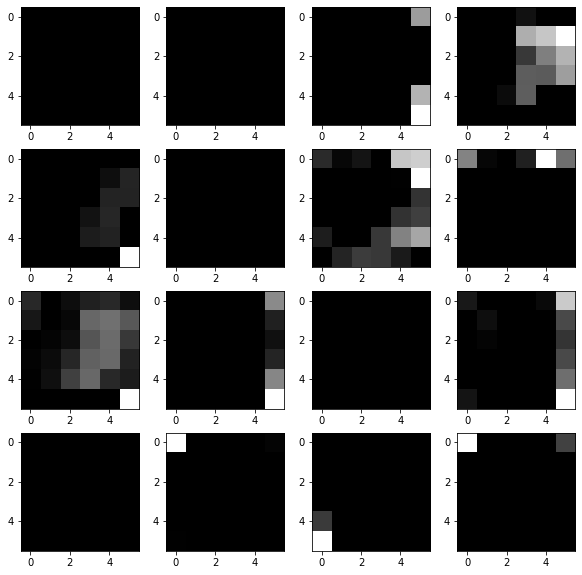

In [21]:
for index, features in enumerate(feature_maps):
    ix = 0
    f, ax = plt.subplots(square, square, figsize = (10, 10))
    print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FEATURES FOR LAYER {index}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for axes in ax:
        for axis in axes:
            axis.imshow(features[0,:,:,ix], cmap = 'gray')
            ix += 1
    plt.show()